# Clustering and Visualizing Protein Structure Sets using ESM-IF

We have ~1000 confident structure predictions for our encapsulin hits, and accompanying representations generated from ESM-IF's encoder output. These representations are vectors of the same length as the original protein sequences - we'd like to experiment with dimensionality reduction, visualization, and clustering these vectors to uncover patterns in the data.

In order to do this we need vectors of uniform length, so let's pad all of them with zeros to the length of the longest one:

In [35]:
import numpy as np
import os

#Make a list of tuples containing (MGYP, Representation, Length)
vector_data = [(file.replace(".pdb", "")[:-4], np.loadtxt(f"../structures/representations/{file}"), len(np.loadtxt(f"../structures/representations/{file}"))) for file in os.listdir("../structures/representations/") if file.endswith(".txt")]

#Let's get the maximum length of all representation vectors so we can pad all the other ones to this length
max_length = max([triplet[2] for triplet in vector_data])
print(f"Max length: {max_length}")
X = np.stack([np.pad(array[1], (0, max_length - array[2]), "constant") for array in vector_data])
X.shape

Max length: 849


(957, 849)

Now let's experiment with a few different algorithms. First, let's use PCA to reduce the number of dimensions to 50, and then use t-SNE to plot this:

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px

pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 957 samples in 0.001s...
[t-SNE] Computed neighbors for 957 samples in 0.138s...
[t-SNE] Computed conditional probabilities for sample 957 / 957
[t-SNE] Mean sigma: 0.020098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.310417
[t-SNE] KL divergence after 1000 iterations: 0.546710


In [37]:
df_tsne = pd.DataFrame(tsne_results, columns=["Component 1", "Component 2"])
df_tsne["Length"] = [array[2] for array in vector_data]
fig = px.scatter(df_tsne, x="Component 1", y="Component 2", color="Length")

fig.show()

Interesting initial findings - looks like that X component correlates with the length of the protein sequence...

Let's test different values for the t-SNE perplexity parameter (usually recommended between 5 and 50):

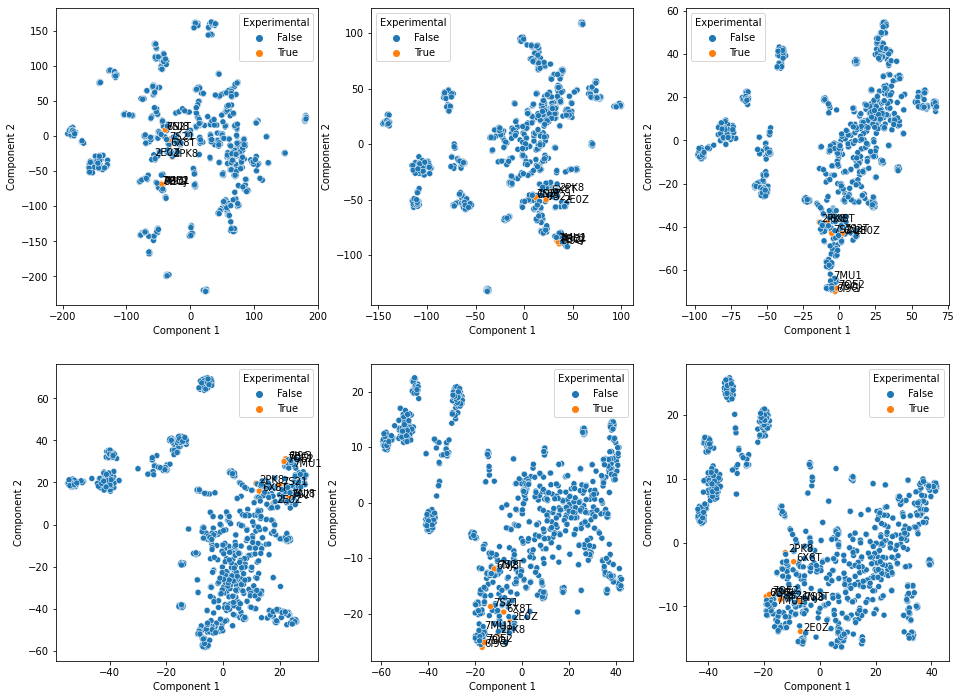

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt


perplexity_values = [5, 10, 20, 30, 40, 50]
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

for i, value in enumerate(perplexity_values):

    tsne = TSNE(n_components=2, verbose=0, perplexity=value, n_iter=10000, learning_rate=200)
    tsne_results = tsne.fit_transform(X_pca)

    df_tsne = pd.DataFrame(tsne_results, columns=["Component 1", "Component 2"])
    df_tsne["Length"] = [array[2] for array in vector_data]
    df_tsne["Name"] = [vector[0] for vector in vector_data]
    df_tsne["Experimental"] = ~df_tsne["Name"].str.startswith("MGYP")

    sns.scatterplot(data=df_tsne, x="Component 1", y="Component 2", hue="Experimental", ax=axs.flat[i])

    for row in df_tsne[df_tsne["Experimental"] == True].iterrows():
        row = row[1].to_dict()
        x = row["Component 1"]
        y = row["Component 2"]
        label = row["Name"]

        axs.flat[i].text(x + 1, y + 0.1, label)


plt.show()

Looks like 20 perplexity and above brings out some meaningful structure to the data but below that we get a randomly distributed mess.

Let's see what PCA with two components looks like now:

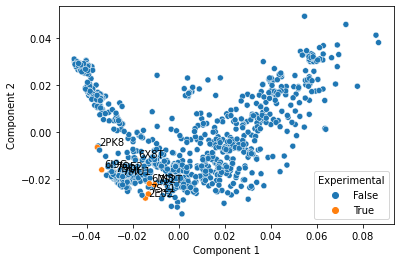

In [81]:
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=["Component 1", "Component 2"])
df_pca["Length"] = [array[2] for array in vector_data]
df_pca["Name"] = [vector[0] for vector in vector_data]
df_pca["Experimental"] = ~df_pca["Name"].str.startswith("MGYP")


sns.scatterplot(data=df_pca, x="Component 1", y="Component 2", hue="Experimental")
for row in df_pca[df_pca["Experimental"] == True].iterrows():
        row = row[1].to_dict()
        x = row["Component 1"]
        y = row["Component 2"]
        label = row["Name"]

        plt.text(x + 0.001, y + 0.001, label)

plt.show()

In [83]:
pca_viz.explained_variance_ratio_

array([0.1749566 , 0.06112733])

Looks pretty poor - no real clustering or separation visible and the fraction of explained variance is only ~23%!

Now let's re-run the t-SNE with `perplexity=50` and see if we can do k-means clustering of this:

In [84]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, verbose=0, perplexity=value, n_iter=10000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca)

df_tsne = pd.DataFrame(tsne_results, columns=["Component 1", "Component 2"])
df_tsne["Length"] = [array[2] for array in vector_data]
df_tsne["Name"] = [vector[0] for vector in vector_data]
df_tsne["Experimental"] = ~df_tsne["Name"].str.startswith("MGYP")

array([0.1749566 , 0.06112733, 0.04152081, 0.03625129, 0.02601039,
       0.02135294, 0.01940088, 0.01901124, 0.0166019 , 0.01597493,
       0.01486557, 0.01420962, 0.01349602, 0.01221493, 0.01166768,
       0.01130221, 0.01037174, 0.00967746, 0.00922939, 0.00887084,
       0.00852357, 0.00826552, 0.00776418, 0.00759101, 0.00719641,
       0.00689398, 0.00673644, 0.00660908, 0.00617799, 0.00613324,
       0.00579456, 0.00566017, 0.0054248 , 0.00535834, 0.005179  ,
       0.00498191, 0.00494245, 0.00480437, 0.00466479, 0.00446895,
       0.00439627, 0.00438297, 0.00420264, 0.00412602, 0.00405218,
       0.00395272, 0.00383881, 0.00375277, 0.00369811, 0.00365454])

Text(0, 0.5, 'Sum of squares')

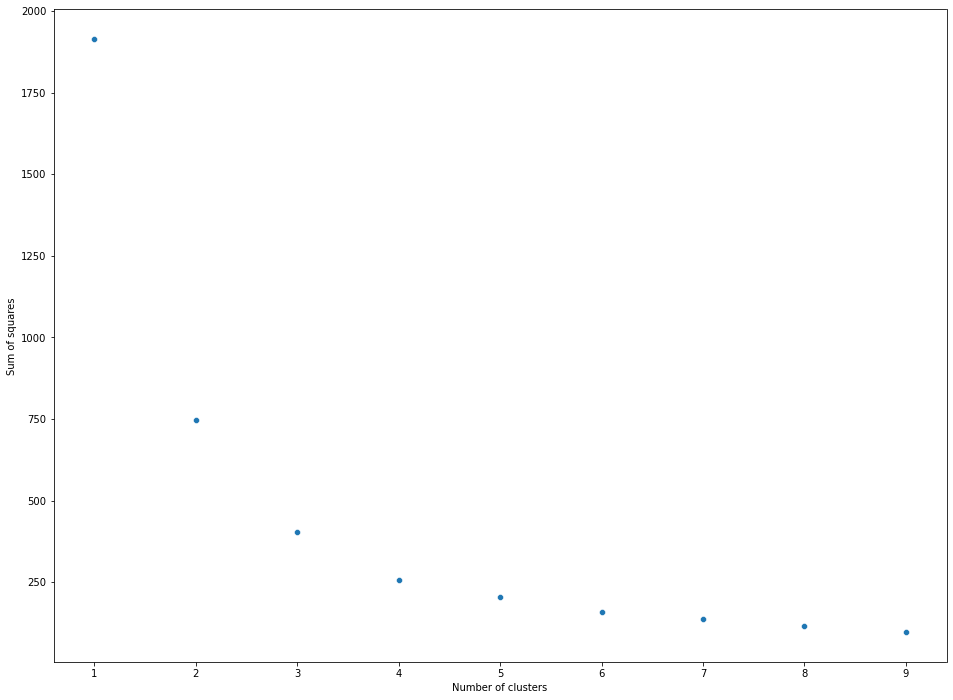

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_tsne.loc[:, ["Component 1", "Component 2"]])

sse = {}
estimators = {}
for k in range(1, 10):
    kmeans = KMeans(n_init=10, n_clusters=k).fit(X_scaled)
    sse[k] = kmeans.inertia_
    estimators[k] = kmeans

plt.figure(figsize=(16, 12))
sns.scatterplot(x=sse.keys(), y=sse.values())
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares")

The classic "elbow" plot shows that around 4 clusters is where the sum-of-squares error starts to fall off so let's examine this data:

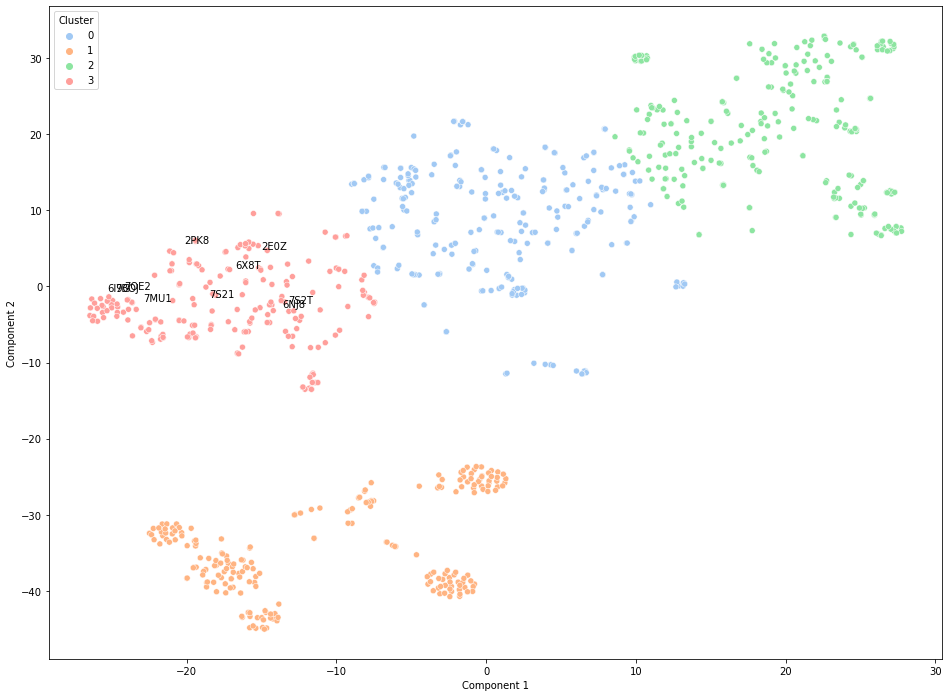

In [104]:
df_tsne["Cluster"] = estimators[4].labels_
plt.figure(figsize=(16, 12))
sns.scatterplot(data=df_tsne, x="Component 1", y="Component 2", hue="Cluster", palette="pastel")
for row in df_tsne[df_tsne["Experimental"] == True].iterrows():
        row = row[1].to_dict()
        x = row["Component 1"]
        y = row["Component 2"]
        label = row["Name"]

        plt.text(x + 1, y + 1, label)
plt.show()

This looks really exciting!!!!!!!

Let's pick a few sequences from that orange cluster and examine their structures below:

In [115]:
import py3Dmol

def view_pdb(fpath, chain_id):
        with open(fpath) as ifile:
            system = "".join([x for x in ifile])

        view = py3Dmol.view(width=600, height=400)
        view.addModelsAsFrames(system)
        view.setStyle({'model': -1, 'chain': chain_id}, {"cartoon": {'color': 'spectrum'}})
        view.zoomTo()
        view.show()

df_tsne[df_tsne["Cluster"] == 0]

,Component 1,Component 2,Length,Name,Experimental,Cluster
0,-5.154327,13.904502,320,MGYP003332394819,False,0
7,4.785041,9.088642,328,MGYP001376145772,False,0
10,-5.706561,14.293064,321,MGYP000157970448,False,0
11,1.385028,1.557947,310,MGYP003392391534,False,0
13,2.204099,4.424746,335,MGYP001585338911,False,0
...,...,...,...,...,...,...
935,8.020700,12.847552,356,MGYP001626144185,False,0
937,0.816116,7.115415,323,MGYP003669342811,False,0
944,-7.245087,1.881516,307,MGYP000037551163,False,0
948,8.388540,5.469159,335,MGYP003145882433,False,0


In [126]:
#I'm using this so I can copy-paste an MGYP from the DataFrame output above without having to check the file path manually
import glob
mgyp = "MGYP003145882433"
path = glob.glob(f"../structures/confident/{mgyp}*.pdb")[0]

view_pdb(path, "A")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [125]:
pdb_code = "7MU1"
path = glob.glob(f"../structures/experimental/{pdb_code}*.pdb")[0]

view_pdb(path, "A")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol